# Features Selection MonoVariate

In [1]:
% matplotlib inline

import time
import pandas as pd

from IPython import display as d

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn import feature_selection as fs

from libs import container
from libs.experiment import (
    WithAnotherExperiment, KFoldExperiment, roc, metrics,
    discretize_classes, clean_features)

## 1. Load Data

In [2]:
start = time.time()

path = "/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/"
data = container.read(path)

print("Removing b220...")
del data["b220"]

for df in data.values():
    df["AmplitudeJH"] = df["AmplitudeJ"] - df["AmplitudeH"]
    df["AmplitudeJK"] = df["AmplitudeJ"] - df["Amplitude"]

Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b261.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b263.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b220.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b264.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b262.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b278.npy'...
Removing b220...


##  2. Preprocess

### 2.1. Discretize the classes

In [3]:
data, classes, sclasses = discretize_classes(data)
d.display(d.Markdown("**Classes**"))
d.display(classes)

d.display(d.Markdown("----"))
d.display(d.Markdown("**Simplified Classes**"))
d.display(sclasses)

**Classes**

{'': 0,
 'Cep-1': 1,
 'Cep-F': 2,
 'LPV-Mira': 3,
 'LPV-OSARG': 4,
 'LPV-SRV': 5,
 'RRLyr-RRab': 6,
 'RRLyr-RRc': 7,
 'RRLyr-RRd': 8,
 'T2Cep-BLHer': 9,
 'T2Cep-RVTau': 10,
 'T2Cep-WVir': 11}

----

**Simplified Classes**

{'': 0, 'Cep': 1, 'LPV': 2, 'RRLyr': 3, 'T2Cep': 4}

### 2.2. Removes all low-variance and "bad" features

In [4]:
X_columns = clean_features(data, "b278")
X_columns = X_columns.drop("AndersonDarling")
X_columns = X_columns[~(X_columns.str.startswith("Freq2_") | X_columns.str.startswith("Freq3_"))]
print("Total features:", X_columns.size)

Removing ['Gskew', 'Period_fit', 'StetsonK'] because null
Removing ['Freq1_harmonics_rel_phase_0', 'Freq2_harmonics_rel_phase_0', 'Freq3_harmonics_rel_phase_0'] because lowvariance
('Total features:', 55)


### 2.3. Selected features

In [5]:
X_columns

Index([u'cnt', u'Amplitude', u'Autocor_length', u'Beyond1Std', u'CAR_mean',
       u'CAR_sigma', u'CAR_tau', u'Con', u'Eta_e', u'FluxPercentileRatioMid20',
       u'FluxPercentileRatioMid35', u'FluxPercentileRatioMid50',
       u'FluxPercentileRatioMid65', u'FluxPercentileRatioMid80',
       u'Freq1_harmonics_amplitude_0', u'Freq1_harmonics_amplitude_1',
       u'Freq1_harmonics_amplitude_2', u'Freq1_harmonics_amplitude_3',
       u'Freq1_harmonics_rel_phase_1', u'Freq1_harmonics_rel_phase_2',
       u'Freq1_harmonics_rel_phase_3', u'LinearTrend', u'MaxSlope', u'Mean',
       u'Meanvariance', u'MedianAbsDev', u'MedianBRP', u'PairSlopeTrend',
       u'PercentAmplitude', u'PercentDifferenceFluxPercentile', u'PeriodLS',
       u'Psi_CS', u'Psi_eta', u'Q31', u'Rcs', u'Skew', u'SmallKurtosis',
       u'Std', u'c89_jk_color', u'c89_hk_color', u'c89_jh_color',
       u'n09_jk_color', u'n09_hk_color', u'n09_jh_color', u'c89_m2', u'c89_m4',
       u'c89_c3', u'n09_m2', u'n09_m4', u'n09_c3', u'A

In [6]:
sclasses

{'': 0, 'Cep': 1, 'LPV': 2, 'RRLyr': 3, 'T2Cep': 4}

b278 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      2500
          3       0.92      0.71      0.80       296

avg / total       0.96      0.96      0.96      2796

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      2500
          3       0.92      0.69      0.79       308

avg / total       0.96      0.96      0.96      2808

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b261 (TEST)
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      2484
          3       0.89      0.77      0.83       222

avg / total       0.97      0.97      0.97      2706

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b264 (TE

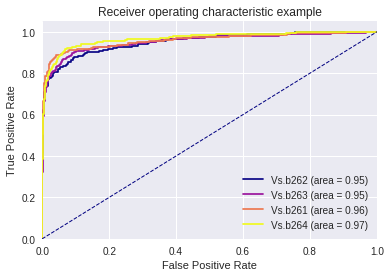

CPU times: user 5.56 s, sys: 88.6 ms, total: 5.65 s
Wall time: 5.54 s


In [7]:
svc_poly = WithAnotherExperiment(
    clf=SVC(kernel='rbf', probability=True), clsnum=sclasses, 
    data=data, pcls="RRLyr", X_columns=X_columns, y_column="scls")
%time roc(svc_poly("b278"))

## Filter features

b278 (TRAIN) Vs. b262 (TEST)
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      2500
          3       0.90      0.74      0.81       296

avg / total       0.96      0.96      0.96      2796

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b263 (TEST)
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      2500
          3       0.90      0.69      0.79       308

avg / total       0.96      0.96      0.96      2808

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b261 (TEST)
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      2484
          3       0.85      0.79      0.82       222

avg / total       0.97      0.97      0.97      2706

--------------------------------------------------------------------------------
b278 (TRAIN) Vs. b264 (TE

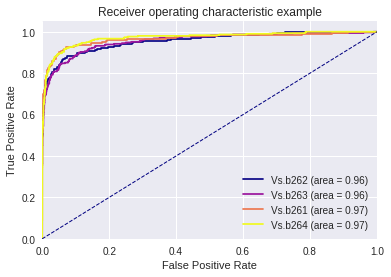

CPU times: user 3.06 s, sys: 83.7 ms, total: 3.15 s
Wall time: 3.04 s


In [8]:
all_df = pd.concat(data.values())
y = all_df["scls"].values

skb = fs.SelectPercentile(percentile=38)
skb.fit(all_df[X_columns].values, y)

fX_columns = X_columns[skb.get_support()]

svc_poly = WithAnotherExperiment(
    clf=SVC(kernel='rbf', probability=True), clsnum=sclasses, 
    data=data, pcls="RRLyr", X_columns=fX_columns, 
    y_column="scls")
%time roc(svc_poly("b278"))

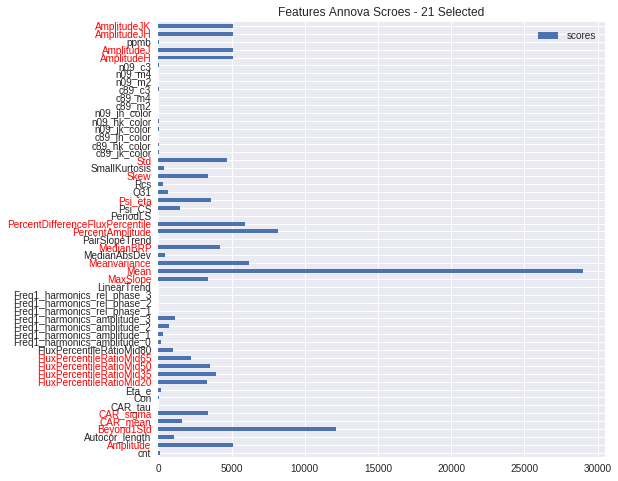

In [9]:
ax = pd.DataFrame(
        {"scores": skb.scores_}, index=X_columns).plot.barh(
    figsize=(8, 8))
ax.set_title("Features Annova Scroes - {} Selected".format(
        skb.get_support().sum()))

for idx in skb.get_support(True):
    ax.get_yticklabels()[idx].set_color("red")

In [10]:
from collections import namedtuple
import numpy as np
from joblib import Parallel, delayed

ItResults = namedtuple("ItResults", ["columns", "result"])
results = []


def _run(select, it, total_it):
    rX_columns = np.random.choice(fX_columns, 11)
    svc_poly = WithAnotherExperiment(
    clf=SVC(kernel='rbf', probability=True), clsnum=sclasses, 
            data=data, pcls="RRLyr", X_columns=rX_columns, verbose=False,
            y_column="scls")
    r = svc_poly("b278")
    print("[DONE] Iteration {}/{}".format(it+1, total_it))
    return ItResults(columns=rX_columns, result=r)


def random_run(total_it):
    with Parallel(n_jobs=-1) as jobs:
        results = jobs(delayed(_run)(11, it, total_it)
                                     for it in range(total_it))
    return results

# %time results = random_run(100)

In [11]:
# params = dict(auc=[], f1_0=[], f1_1=[])
# for ir in results:
#     y_tests = np.hstack([r.y_test for r in ir.result])
#     y_pred = np.hstack([r.predictions for r in ir.result])
#     f1_0, f1_1 = metrics.f1_score(y_tests, y_pred, average=None)
#     auc_mean = np.mean([r.roc_auc for r in ir.result])
#     params["auc"].append(auc_mean)
#     params["f1_0"].append(f1_0)
#     params["f1_1"].append(f1_1)
# df = pd.DataFrame(params)

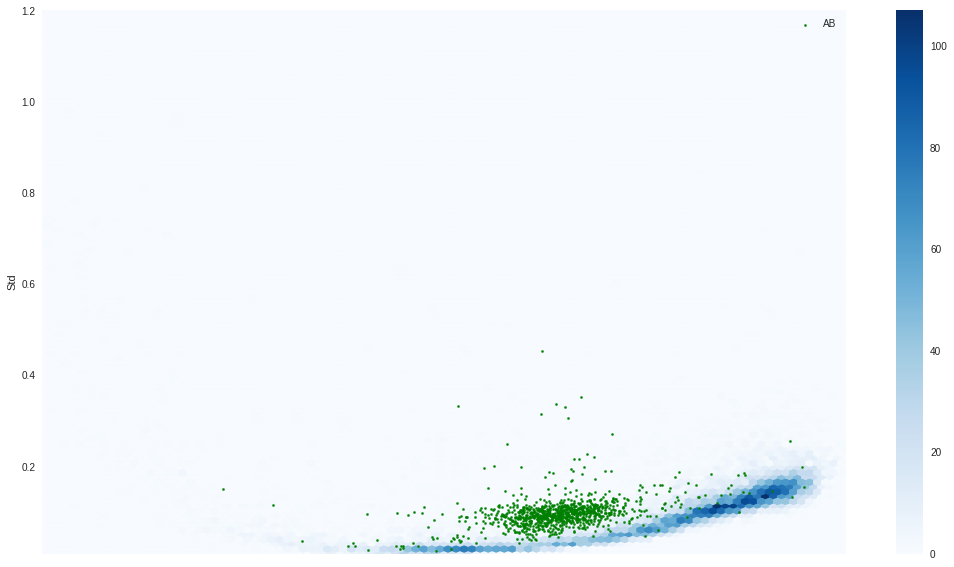

In [43]:
ax =  all_df[all_df.cls == 0].plot.hexbin("Mean", "Std", cmap="Blues", figsize=(18, 10))
all_df[all_df.cls == 6].plot.scatter("Mean", "Std", s=5, color="g", ax=ax, label="AB")
# all_df[all_df.cls == 7].plot.scatter("Mean", "Std", s=5, color="r", ax=ax, label="C")

In [54]:
# for 
# all_df[all_df.scls==0][["Std"]].describe()

,Std
count,12483.000000
mean,0.102100
std,0.069765
min,0.007995
25%,0.047377
50%,0.101940
75%,0.141253
max,1.201786


In [28]:
all_df[all_df.cls==0].shape

(12483, 85)

In [30]:
classes

{'': 0,
 'Cep-1': 1,
 'Cep-F': 2,
 'LPV-Mira': 3,
 'LPV-OSARG': 4,
 'LPV-SRV': 5,
 'RRLyr-RRab': 6,
 'RRLyr-RRc': 7,
 'RRLyr-RRd': 8,
 'T2Cep-BLHer': 9,
 'T2Cep-RVTau': 10,
 'T2Cep-WVir': 11}